In [36]:
from data import DataXRF

from numpy import arange,linspace
from matplotlib.pyplot import plot,subplots,xlim,ylim

In [24]:
data = DataXRF()

In [25]:
data.calibrate_from_file('/home/zdenek/storage/dataXRDXRF/Giulia_XRF/calibration.ini')

In [26]:
data.calibration.fce

<function data.DataXRF.fce_calibration(x, a, b, c)>

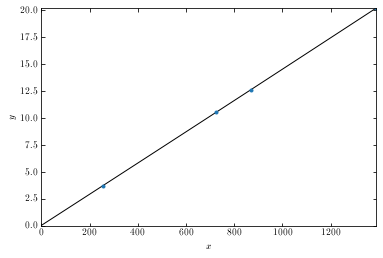

In [28]:
data.calibration.plot()

In [6]:
data.read('/home/zdenek/storage/dataXRDXRF/Giulia_XRF')

Reading XRF data
Done


In [50]:
data.save_h5()

Saving: /home/zdenek/storage/dataXRDXRF/Giulia_XRF/data.h5


In [29]:
data.load_h5('/home/zdenek/storage/dataXRDXRF/Giulia_XRF/data.h5')

Loading: /home/zdenek/storage/dataXRDXRF/Giulia_XRF/data.h5


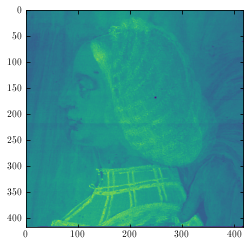

In [30]:
from matplotlib.pyplot import imshow
imshow(data.data.sum(-1)[::-1])

Text(0, 0.5, 'counts')

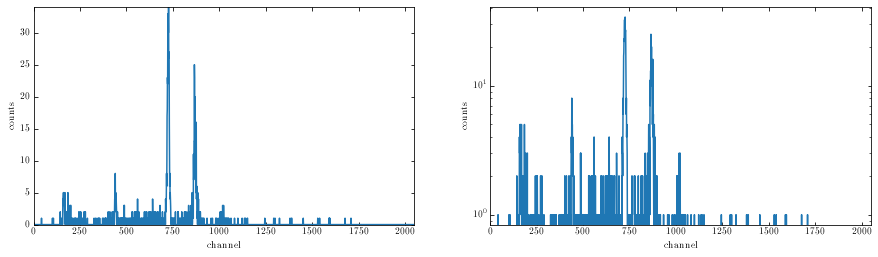

In [31]:
fig,ax = subplots(1,2,figsize=(15,4))
y = data.data[100,201]

ax[0].plot(y)
ax[0].set_xlim(0,2048)
ax[0].set_ylim(0,y.max())
ax[0].set_xlabel('channel')
ax[0].set_ylabel('counts')

ax[1].semilogy(y)
ax[1].set_xlim(0,2048)
ax[1].set_xlabel('channel')
ax[1].set_ylabel('counts')

Text(0, 0.5, 'counts')

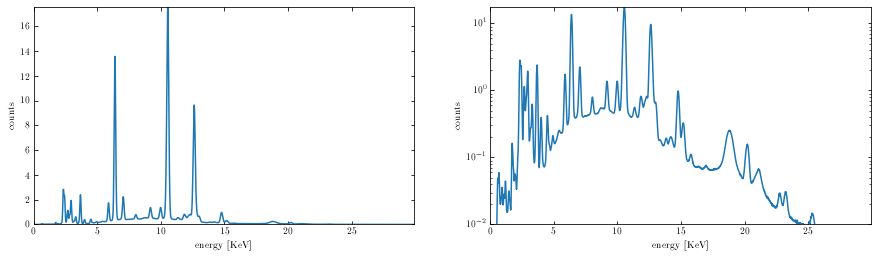

In [32]:
fig,ax = subplots(1,2,figsize=(15,4))
y = data.data.mean(0).mean(0)
x = data.x

ax[0].plot(x,y)
ax[0].set_xlim(0,x.max())
ax[0].set_ylim(0,y.max())
ax[0].set_xlabel('energy [KeV]')
ax[0].set_ylabel('counts')

ax[1].semilogy(x,y)
ax[1].set_xlim(0,x.max())
ax[1].set_ylim(1e-2,y.max())
ax[1].set_xlabel('energy [KeV]')
ax[1].set_ylabel('counts')

In [47]:
from scipy.interpolate import interp1d

In [66]:
x = data.x
y = data.data.mean(0).mean(0)

f = interp1d(x,y,fill_value='extrapolate')

new_x = linspace(0,30,256)
new_y = f(new_x)

(10.0, 11.0)

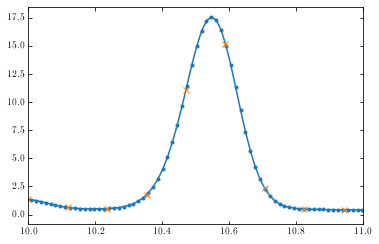

In [67]:
plot(x,y,'.-')
plot(new_x,new_y,'x')

xlim(10,11)